## Setup

In [1]:
IMAGE_DIR = "../images/"
SEED = 42
N_SPLITS = 10
TEST_SIZE = 0.2
CV = 2
QUESTION_ANSWER = False
DATASET = "../data/texas_dataset.xlsx"

In [2]:
from pathlib import Path

IMAGE_DIR = Path(IMAGE_DIR)

In [3]:
import sys
sys.path.append("../")
print(sys.version)

import spacy
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_predict, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, cohen_kappa_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm_notebook
from xgboost import XGBClassifier

3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]


In [4]:
warnings.filterwarnings('always')
np.random.seed(seed=SEED)

## Data Analysis

In [5]:
columns_dict = {
  "Topic": "topic",
  "Human Evaluation": "human_evaluation",
  "Round_score": "human_evaluation",
  "Question": "question",
  "Student Answer": "answer",
  "Question_ID": "question_id",
  "Score": "score"
}
dataset = pd.read_excel(DATASET)
dataset.rename(columns=columns_dict, inplace=True)
dataset.head()

,ID,question_id,question,Instructor answers,answer,score,human_evaluation
0,1,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,High risk problems are address in the prototy...,3.5,4
1,2,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,To simulate portions of the desired final pro...,5.0,5
2,3,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,A prototype program simulates the behaviors o...,4.0,4
3,4,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,Defined in the Specification phase a prototyp...,5.0,5
4,5,2023-01-01,What is the role of a prototype program in pr...,To simulate the behaviour of portions of the ...,It is used to let the users have a first idea...,3.0,3


In [6]:
X = dataset.drop("human_evaluation", axis=1)
y = dataset["human_evaluation"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(1953, 489, 1953, 489)

In [7]:
train_set = pd.concat([X_train, y_train], axis=1)
train_set.head()

,ID,question_id,question,Instructor answers,answer,score,human_evaluation
869,870,2023-02-05,"In one sentence, what is the main idea impleme...","Taking one array element at a time, from left ...",Selection sort searches the whole array for th...,4.5,5
307,308,2023-04-02,When does C++ create a default constructor?,"If no constructor is provided, the compiler pr...",When no constructor was specified in the const...,5.0,5
1700,1701,2023-01-10,What is a tree?,"A collection of nodes, which has a special nod...",an infinite set of nodes that have a root and ...,3.5,4
582,583,2023-06-03,"When defining a recursive function, what are p...","If the recursion step is defined incorrectly, ...","No base case, or an incorrectly written recurs...",5.0,5
383,384,2023-07-02,What is the role of a header-file?,"To store a class interface, including data mem...",the role of a header file list all the functio...,4.5,5


### Dealing with the unbalanced data problem

In [8]:
label_5_ds = train_set[train_set["human_evaluation"] == 5]
label_5_ds = pd.concat([label_5_ds] * 1, axis=0, ignore_index=True)

label_4_ds = train_set[train_set["human_evaluation"] == 4]
label_4_ds = pd.concat([label_4_ds] * 4, axis=0, ignore_index=True)

label_3_ds = train_set[train_set["human_evaluation"] == 3]
label_3_ds = pd.concat([label_3_ds] * 5, axis=0, ignore_index=True)

label_2_ds = train_set[train_set["human_evaluation"] == 2]
label_2_ds = pd.concat([label_2_ds] * 10, axis=0, ignore_index=True)

label_1_ds = train_set[train_set["human_evaluation"] == 1]
label_1_ds = pd.concat([label_1_ds] * 50, axis=0, ignore_index=True)

label_0_ds = train_set[train_set["human_evaluation"] == 0]
label_0_ds = pd.concat([label_0_ds] * 53, axis=0, ignore_index=True)

train_set = pd.concat([label_0_ds, label_1_ds, label_2_ds, label_3_ds, label_4_ds, label_5_ds], axis=0)
len(train_set)

6736

In [9]:
train_set = train_set.sample(frac=1, random_state=SEED).reset_index(drop=True)
train_set.head()

,ID,question_id,question,Instructor answers,answer,score,human_evaluation
0,1316,2023-07-07,What is the main disadvantage of a doubly-link...,Extra space required to store the back pointers.,not answered,0.0,0
1,2093,2023-08-11,What is the main difference between a string o...,The char[] will automatically add a null \0 ch...,"the variable of type char[], each character is...",2.0,2
2,1603,2023-04-09,How can you implement a queue with a list?,Keep the rear of the queue pointing to the tai...,"create a node with the input data, continue to...",4.0,4
3,204,2023-01-02,What is typically included in a class definition?,Data members (attributes) and member functions.,"For us it is usually a set, get, and displayM...",2.0,2
4,2439,2023-10-12,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2<br><br>,1.5,2


In [10]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736 entries, 0 to 6735
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  6736 non-null   int64         
 1   question_id         6736 non-null   datetime64[ns]
 2   question            6736 non-null   object        
 3   Instructor answers  6736 non-null   object        
 4   answer              6736 non-null   object        
 5   score               6736 non-null   float64       
 6   human_evaluation    6736 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 368.5+ KB


In [11]:
test_set = pd.concat([X_test, y_test], axis=1)
test_set.head()

,ID,question_id,question,Instructor answers,answer,score,human_evaluation
1322,1323,2023-01-08,What is a stack?,"A data structure that can store elements, whic...",A data structure that stores data using LIFO.,5.0,5
1134,1135,2023-01-07,What is a linked list?,A collection of elements that can be allocated...,"Consists of sequence of nodes, each containing...",4.5,5
1875,1876,2023-01-11,What are the elements typically included in a ...,Function members and data members.,The return value and the accepted value.,1.5,2
705,706,2023-03-04,How are arrays passed to functions?,by reference.,You pass the name of the array to the function...,5.0,5
2270,2271,2023-04-12,"Briefly, how does selection sort work?",It selects the minimum from an array and place...,It starts at the first element and replaces it...,4.5,5


In [12]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 1322 to 433
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  489 non-null    int64         
 1   question_id         489 non-null    datetime64[ns]
 2   question            489 non-null    object        
 3   Instructor answers  489 non-null    object        
 4   answer              489 non-null    object        
 5   score               489 non-null    float64       
 6   human_evaluation    489 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 30.6+ KB


In [13]:
train_set[['human_evaluation']].describe()

,human_evaluation
count,6736.000000
mean,2.637173
std,1.739930
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,5.000000


In [14]:
train_set.dropna(inplace=True)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736 entries, 0 to 6735
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  6736 non-null   int64         
 1   question_id         6736 non-null   datetime64[ns]
 2   question            6736 non-null   object        
 3   Instructor answers  6736 non-null   object        
 4   answer              6736 non-null   object        
 5   score               6736 non-null   float64       
 6   human_evaluation    6736 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 368.5+ KB


In [15]:
test_set[['human_evaluation']].describe()

,human_evaluation
count,489.000000
mean,4.229039
std,1.094273
min,0.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [16]:
test_set.dropna(inplace=True)
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 1322 to 433
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  489 non-null    int64         
 1   question_id         489 non-null    datetime64[ns]
 2   question            489 non-null    object        
 3   Instructor answers  489 non-null    object        
 4   answer              489 non-null    object        
 5   score               489 non-null    float64       
 6   human_evaluation    489 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 30.6+ KB


In [17]:
def save_fig(image_dir: str, fig_id: str, tight_layout=True, fig_extension: str = "png", resolution: int = 300):
    path = Path(image_dir) / Path(f"{fig_id}.{fig_extension}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

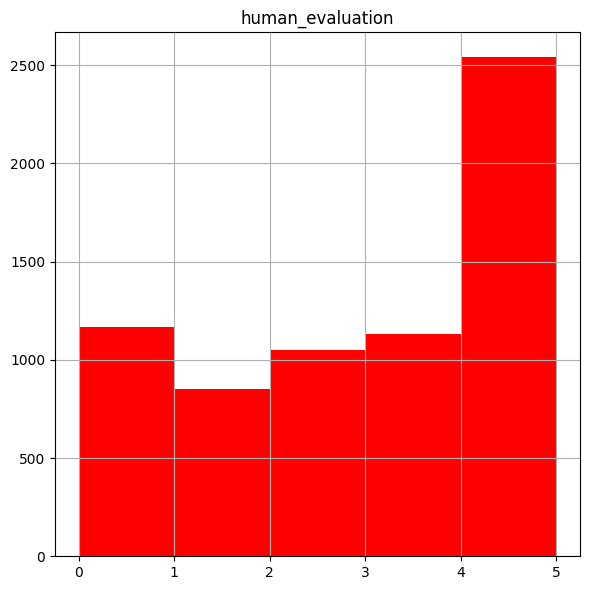

In [18]:
train_set[['human_evaluation']].hist(bins=5, figsize=(6, 6), color='red')
save_fig(image_dir=IMAGE_DIR, fig_id='attributes_histogram_plots')
plt.show()

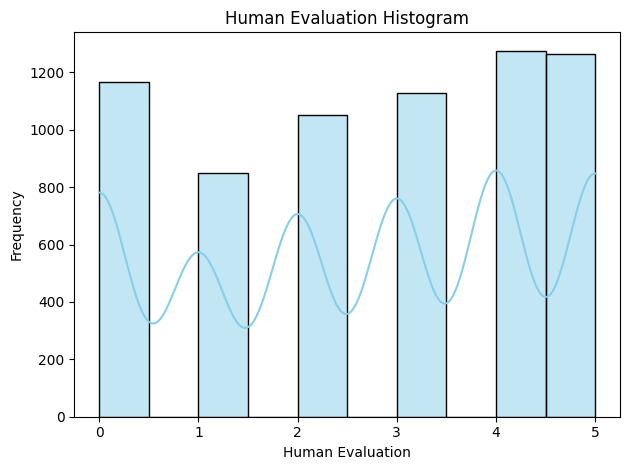

In [19]:
sns.histplot(data=train_set, x='human_evaluation', color='skyblue', kde=True, bins=10)
plt.title('Human Evaluation Histogram')
plt.xlabel("Human Evaluation")
plt.ylabel("Frequency")
save_fig(image_dir=IMAGE_DIR, fig_id='human_evaluation_histogram')
plt.show()

## Preprocessing

### Cleansing

In [20]:
def cleanse(text: str, nlp: spacy.Language) -> str:
    text = text.lower()
    doc = nlp(text)
    cleansed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    cleansed_text = ' '.join(cleansed_tokens)
    return cleansed_text


tqdm_notebook.pandas()
nlp = spacy.load('en_core_web_lg')

if QUESTION_ANSWER:
    train_set["input"] = train_set.progress_apply(lambda x: x['question'] + ' ' + x['answer'], axis=1)
    train_set["cleansed"] = train_set['input'].progress_apply(lambda answer: cleanse(str(answer), nlp))
    test_set["input"] = test_set.progress_apply(lambda x: x['question'] + ' ' + x['answer'], axis=1)
    test_set["cleansed"] = test_set['input'].progress_apply(lambda answer: cleanse(str(answer), nlp))
else:
    train_set["cleansed"] = train_set['answer'].progress_apply(lambda answer: cleanse(str(answer), nlp))
    test_set["cleansed"] = test_set['answer'].progress_apply(lambda answer: cleanse(str(answer), nlp))

display(train_set.head())
display(test_set.head())

  0%|          | 0/6736 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

,ID,question_id,question,Instructor answers,answer,score,human_evaluation,cleansed
0,1316,2023-07-07,What is the main disadvantage of a doubly-link...,Extra space required to store the back pointers.,not answered,0.0,0,answer
1,2093,2023-08-11,What is the main difference between a string o...,The char[] will automatically add a null \0 ch...,"the variable of type char[], each character is...",2.0,2,variable type char character store different m...
2,1603,2023-04-09,How can you implement a queue with a list?,Keep the rear of the queue pointing to the tai...,"create a node with the input data, continue to...",4.0,4,create node input datum continue add list de...
3,204,2023-01-02,What is typically included in a class definition?,Data members (attributes) and member functions.,"For us it is usually a set, get, and displayM...",2.0,2,usually set displaymessge message tell prope...
4,2439,2023-10-12,How many steps does it take to search a node i...,The height of the tree.,( n(n-1) ) / 2<br><br>,1.5,2,n(n-1 2 < br><br >


,ID,question_id,question,Instructor answers,answer,score,human_evaluation,cleansed
1322,1323,2023-01-08,What is a stack?,"A data structure that can store elements, whic...",A data structure that stores data using LIFO.,5.0,5,data structure store datum lifo
1134,1135,2023-01-07,What is a linked list?,A collection of elements that can be allocated...,"Consists of sequence of nodes, each containing...",4.5,5,consist sequence node contain number datum fie...
1875,1876,2023-01-11,What are the elements typically included in a ...,Function members and data members.,The return value and the accepted value.,1.5,2,return value accepted value
705,706,2023-03-04,How are arrays passed to functions?,by reference.,You pass the name of the array to the function...,5.0,5,pass array function.<br > for:<br > int bin 10...
2270,2271,2023-04-12,"Briefly, how does selection sort work?",It selects the minimum from an array and place...,It starts at the first element and replaces it...,4.5,5,start element replace small element find right...


### TF-IDF

In [21]:
X_train = train_set['cleansed'].to_numpy()
X_test = test_set['cleansed'].to_numpy()
y_train = train_set['human_evaluation'].to_numpy()
y_test = test_set['human_evaluation'].to_numpy()

#### SVM

In [22]:
tfidf_svm_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=True,
                stop_words="english",
                max_df=0.85,
                min_df=2,
                use_idf=True,
                sublinear_tf=False,
            ),
        ),
        (
            "svm_ovr",
            OneVsRestClassifier(
                SVR(
                    kernel="rbf",
                    gamma=0.1,
                    coef0=0.0,
                    C=1.0,
                )
            ),
        ),
    ]
)


tfidf_svm_pipeline.fit(X_train, y_train)
tfidf_svm_ovr_y_pred = tfidf_svm_pipeline.predict(X_test)
report = classification_report(y_test, tfidf_svm_ovr_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.25      1.00      0.40         2
           1       0.50      0.44      0.47         9
           2       0.15      0.24      0.18        37
           3       0.26      0.28      0.27        64
           4       0.36      0.35      0.35        92
           5       0.74      0.66      0.70       285

    accuracy                           0.52       489
   macro avg       0.38      0.50      0.40       489
weighted avg       0.55      0.52      0.53       489



#### Random Forest Classification

In [23]:
tfidf_rf_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=True,
                stop_words="english",
                max_df=0.85,
                min_df=2,
                use_idf=True,
                sublinear_tf=False,
            ),
        ),
        ("rfc", RandomForestClassifier(n_estimators=400, random_state=SEED)),
    ]
)

tfidf_rf_pipeline.fit(X_train, y_train)
tfidf_rf_y_pred = tfidf_rf_pipeline.predict(X_test)
report = classification_report(y_test, tfidf_rf_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.17      1.00      0.29         2
           1       1.00      0.44      0.62         9
           2       0.33      0.14      0.19        37
           3       0.43      0.16      0.23        64
           4       0.50      0.27      0.35        92
           5       0.69      0.93      0.79       285

    accuracy                           0.63       489
   macro avg       0.52      0.49      0.41       489
weighted avg       0.59      0.63      0.58       489



#### Decision Tree Classification

In [24]:
tfidf_tree_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=True,
                stop_words="english",
                max_df=0.85,
                min_df=2,
                use_idf=True,
                sublinear_tf=False,
            ),
        ),
        ("dtc", DecisionTreeClassifier(random_state=SEED)),
    ]
)

tfidf_tree_pipeline.fit(X_train, y_train)
tfidf_tree_y_pred = tfidf_tree_pipeline.predict(X_test)
report = classification_report(y_test, tfidf_tree_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.12      1.00      0.22         2
           1       0.50      0.44      0.47         9
           2       0.26      0.32      0.29        37
           3       0.22      0.16      0.18        64
           4       0.28      0.29      0.28        92
           5       0.71      0.68      0.69       285

    accuracy                           0.51       489
   macro avg       0.35      0.48      0.36       489
weighted avg       0.52      0.51      0.51       489



#### XGB

In [25]:
tfidf_xgb_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=True,
                stop_words="english",
                max_df=0.85,
                min_df=2,
                use_idf=True,
                sublinear_tf=False,
            ),
        ),
        ("xgboost", XGBClassifier(random_state=SEED)),
    ]
)

tfidf_xgb_pipeline.fit(X_train, y_train)
tfidf_xgb_y_pred = tfidf_xgb_pipeline.predict(X_test)
report = classification_report(y_test, tfidf_xgb_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.11      1.00      0.20         2
           1       0.80      0.44      0.57         9
           2       0.24      0.11      0.15        37
           3       0.33      0.39      0.36        64
           4       0.40      0.39      0.39        92
           5       0.74      0.73      0.74       285

    accuracy                           0.57       489
   macro avg       0.44      0.51      0.40       489
weighted avg       0.58      0.57      0.57       489



### Comparative Analysis

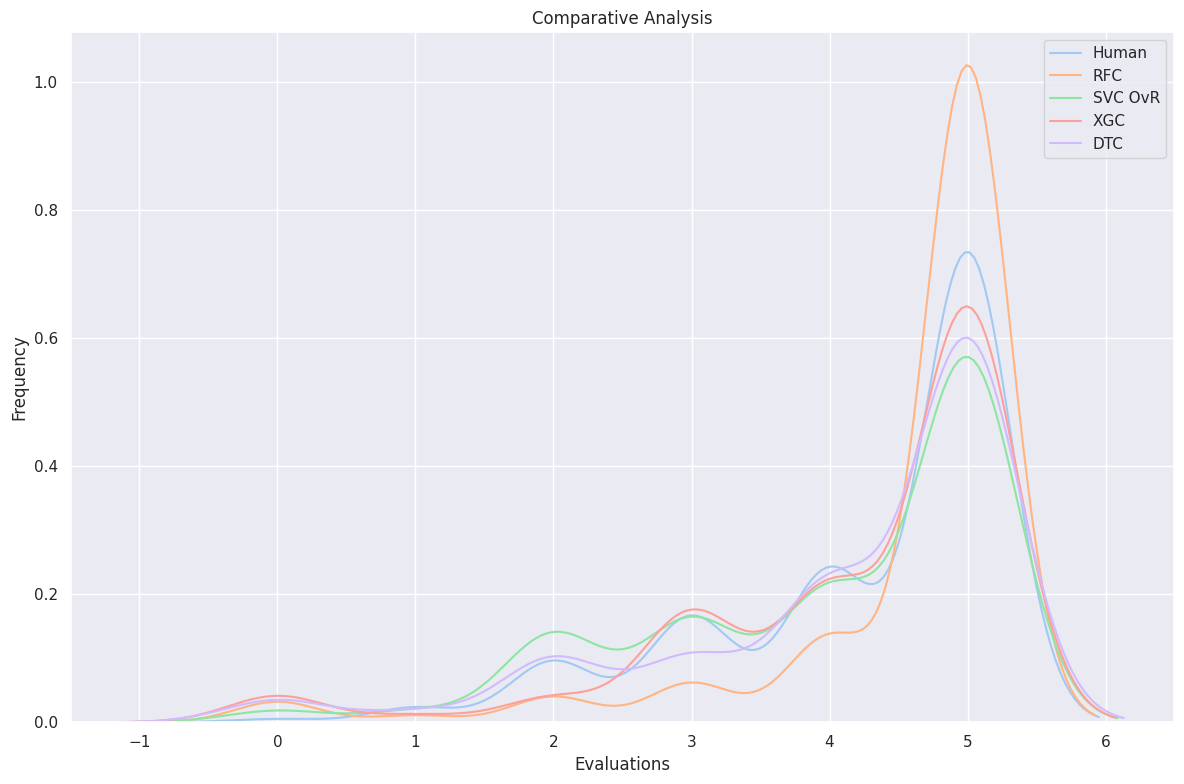

In [26]:
sns.set_theme(style="darkgrid", palette="pastel")
plt.figure(figsize=(12, 8))
sns.kdeplot(data=test_set['human_evaluation'], label='Human')
sns.kdeplot(data=tfidf_rf_y_pred, label='RFC')
sns.kdeplot(data=tfidf_svm_ovr_y_pred, label='SVC OvR')
sns.kdeplot(data=tfidf_xgb_y_pred, label='XGC')
sns.kdeplot(data=tfidf_tree_y_pred, label='DTC')
plt.title('Comparative Analysis')
plt.xlabel("Evaluations")
plt.ylabel("Frequency")
plt.legend()
save_fig(image_dir=IMAGE_DIR, fig_id='comparative_analysis')
plt.show()

In [27]:
tfidf_svm_ovr_kappa = cohen_kappa_score(y_test, tfidf_svm_ovr_y_pred)
tfidf_rf_kappa = cohen_kappa_score(y_test, tfidf_rf_y_pred)
tfidf_tree_kappa = cohen_kappa_score(y_test, tfidf_tree_y_pred)
tfidf_xgb_kappa = cohen_kappa_score(y_test, tfidf_xgb_y_pred)

In [28]:
kappas = {
    "tfidf_svm_ovr_kappa": tfidf_svm_ovr_kappa,
    "tfidf_rf_kappa": tfidf_rf_kappa,
    "tfidf_tree_kappa": tfidf_tree_kappa,
    "tfidf_xgb_kappa": tfidf_xgb_kappa
}

kappas_df = pd.DataFrame(data=[kappas]).T.reset_index()
kappas_df.columns = ["Metric", "Score"]
kappas_df

,Metric,Score
0,tfidf_svm_ovr_kappa,0.238528
1,tfidf_rf_kappa,0.286678
2,tfidf_tree_kappa,0.201524
3,tfidf_xgb_kappa,0.293138
